In [1]:
import sys
from dotenv import dotenv_values
import binance
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

In [2]:
print(sys.version)
print(f'Binance client: {binance.__version__}')
print(f'Pandas verrsion: {pd.__version__}')
print(f'Matplotlib version: {matplotlib.__version__}')
print(f'Seaborn version: {sns.__version__}')

3.10.8 (main, Oct 12 2022, 09:46:29) [Clang 14.0.0 (clang-1400.0.29.102)]
Binance client: 1.0.16
Pandas verrsion: 1.5.1
Matplotlib version: 3.6.2
Seaborn version: 0.12.1


In [3]:
sns.set_style('whitegrid')
sns.set_context("paper")
config = dotenv_values('env')

In [4]:
api_key = config.get('API_KEY')
secret_key = config.get('SECRET_KEY')
binance_client = binance.Client(api_key, secret_key)
timestamp = binance_client.get_server_time()["serverTime"]
print(f'Server time: {timestamp} ~ {datetime.fromtimestamp(timestamp / 1000)}')

Server time: 1669053349717 ~ 2022-11-22 00:55:49.717000


In [5]:
tickers = binance_client.get_ticker()
tickers = pd.DataFrame(tickers)
tickers = tickers.astype({'symbol': 'str', 'lastPrice': 'float64'})
tickers = tickers[tickers['symbol'].str.endswith('BUSD')]
tickers = tickers.assign(asset=lambda r: r.symbol.str[:-4])
tickers.reset_index(drop=True, inplace=True)

In [6]:
tickers.head()

,symbol,priceChange,priceChangePercent,weightedAvgPrice,prevClosePrice,lastPrice,lastQty,bidPrice,bidQty,askPrice,...,highPrice,lowPrice,volume,quoteVolume,openTime,closeTime,firstId,lastId,count,asset
0,BNBBUSD,-13.50000000,-5.028,260.03916995,268.50000000,255.0000,0.05000000,254.90000000,56.09700000,255.00000000,...,269.60000000,253.50000000,393815.49700000,102407454.95170000,1668966950253,1669053350253,184490797,184697129,206333,BNB
1,BTCBUSD,-521.98000000,-3.158,16133.70977198,16528.44000000,16006.4400,0.02982000,16006.48000000,0.10246000,16007.31000000,...,16591.99000000,15871.55000000,149786.17233000,2416606632.22779020,1668966950261,1669053350261,632922895,636159798,3236904,BTC
2,XRPBUSD,-0.01630000,-4.382,0.35555757,0.37200000,0.3557,3530.00000000,0.35570000,33201.00000000,0.35580000,...,0.37890000,0.34510000,213496009.00000000,75910122.36280000,1668966950041,1669053350041,74929920,75076871,146952,XRP
3,ETHBUSD,-66.24000000,-5.651,1129.59580988,1172.24000000,1106.0000,2.64090000,1106.09000000,10.78230000,1106.10000000,...,1187.50000000,1100.00000000,528641.60860000,597151346.00506900,1668966950241,1669053350241,429300781,429895879,595099,ETH
4,BCHABCBUSD,0.00000000,0.000,0.00000000,220.16000000,0.0000,0.00000000,0.00000000,0.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,1668672398099,1668758798099,-1,-1,0,BCHABC


In [7]:
info = binance_client.get_account()

In [8]:
balances = pd.DataFrame(info['balances'])
balances = balances.astype({'asset': 'str', 'free': 'float64', 'locked': 'float64'})
balances = balances.loc[(balances['free'] > 0) | (balances['locked'] > 0)]
balances = balances.assign(total=lambda r: r.free + r.locked)
balances = balances[balances['asset'] != 'NFT']
for index, balance in balances.iterrows():
    try:
        price = tickers[tickers['asset'] == balance['asset']]['lastPrice'].iloc[0]
        balances.loc[index, ['free', 'locked', 'total']] = balance[['free', 'locked', 'total']] * price
    except Exception as ex:
        print(balance['asset'], ex)
balances.reset_index(drop=True, inplace=True)

BUSD single positional indexer is out-of-bounds
ETHW single positional indexer is out-of-bounds


In [9]:
balances.head()

,asset,free,locked,total
0,BTC,0.154782,58.743635,58.898417
1,ETH,0.105512,0.000000,0.105512
2,NEO,0.000000,4.089600,4.089600
3,BNB,89.249062,0.000000,89.249062
4,QTUM,0.000000,3.405100,3.405100


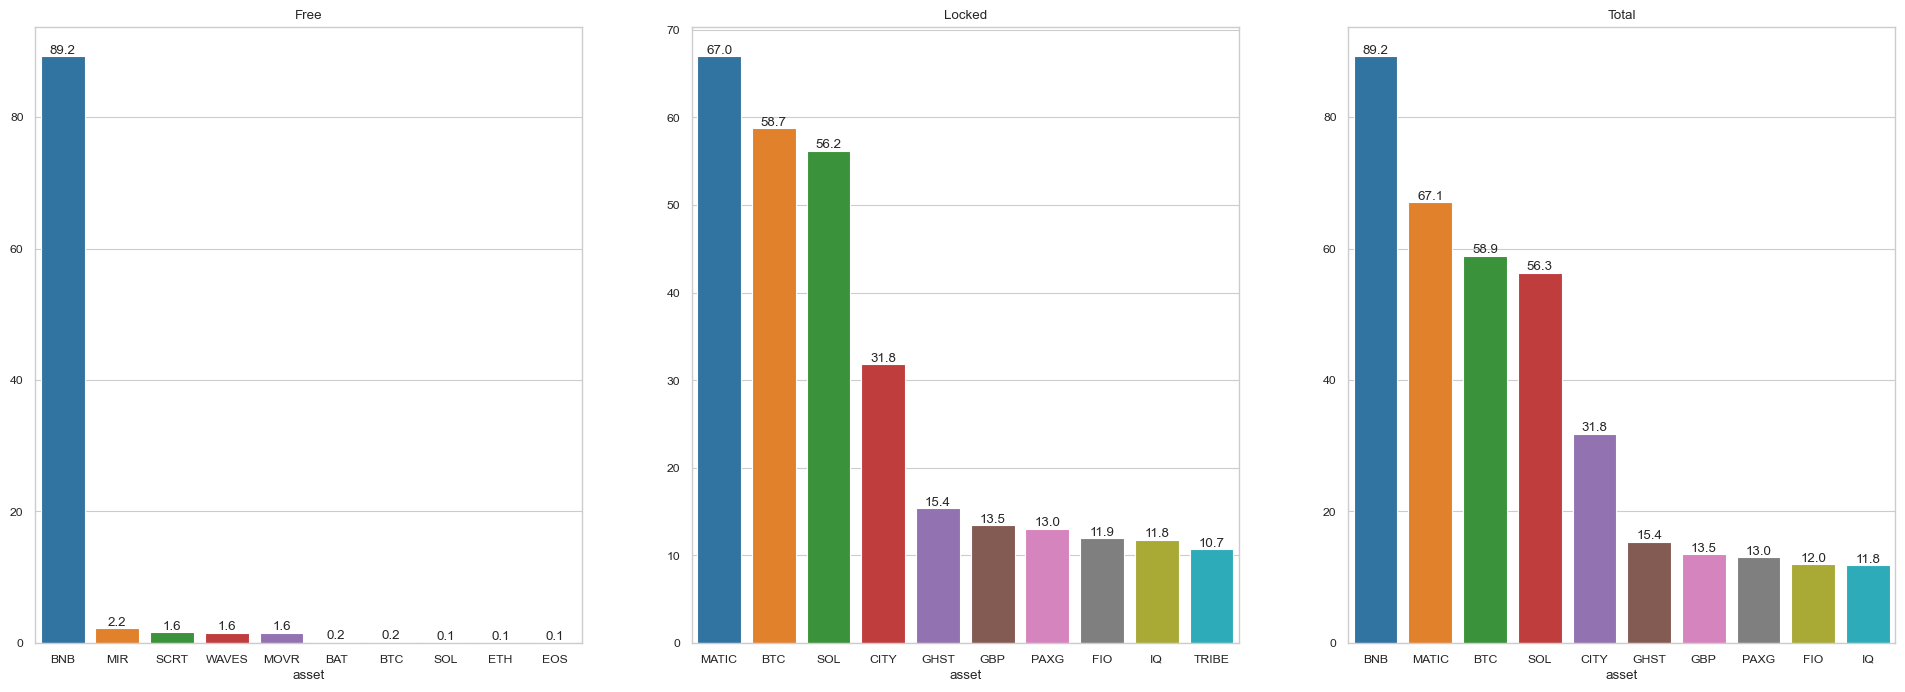

In [10]:
%matplotlib inline
top = 10
colors = sns.color_palette()
figure, axes = plt.subplots(1, 3, figsize=(24, 8))
df = balances.sort_values(by='free', ascending=False)[:top]
sns.barplot(ax=axes[0], data=df, x='asset', y='free').set(title='Free', ylabel=None)
for bars in axes[0].containers:
    axes[0].bar_label(bars, fmt='%.1f')
df = balances.sort_values(by='locked', ascending=False)[:top]
sns.barplot(ax=axes[1], data=df, x='asset', y='locked').set(title='Locked', ylabel=None)
for bars in axes[1].containers:
    axes[1].bar_label(bars, fmt='%.1f')
df = balances.sort_values(by='total', ascending=False)[:top]
sns.barplot(ax=axes[2], data=df, x='asset', y='total').set(title='Total', ylabel=None)
for bars in axes[2].containers:
    axes[2].bar_label(bars, fmt='%.1f')
plt.show()